In [1]:
import torch
from matplotlib import pyplot as plt

checkpoint = torch.load('models/just_pitches_no_drums_warmup2')

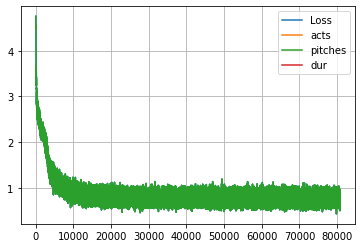

In [2]:
losses = checkpoint['losses']

plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

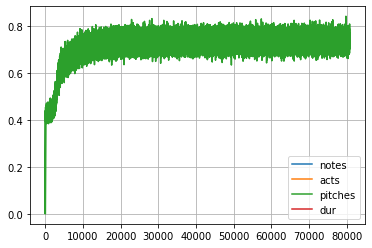

In [3]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

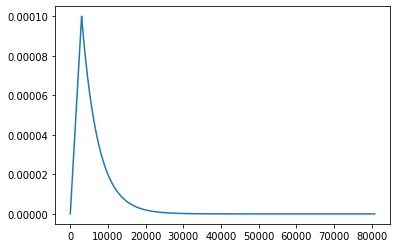

In [4]:
lrs = checkpoint['lrs']
plt.plot(range(1, len(lrs)+1), lrs, label='Lr')

In [12]:
lrs[20000]

1.994802941731902e-06

In [ ]:
losses = checkpoint['losses']
losses['pitches'][-10:]

In [10]:
accs = checkpoint['accuracies']
accs['pitches'][-10:]

[0.7193548679351807,
 0.7464788556098938,
 0.7356142997741699,
 0.722300112247467,
 0.7520661354064941,
 0.773643434047699,
 0.7047781348228455,
 0.7335164546966553,
 0.7414829730987549,
 0.7537878751754761]